# General Data

In the last years the prices for rent and the prices to buy a house increases heavily. To estimate which economic factor has the strongest influence on this increason the prices will examine in this notebook. The most important factors for the american economie are: gross domestic product, oil price, gold price, unemployment rate, fed interest rate and the inflation. The questions are do these factors affect the prices and if they do how strong.

To answer this questions several regression model will be applied to a merged dataset consistent out of all individual dataset. Due to the number of attributes on each date the explainability tools will be used to interpret the magnitude of influence.

## Parameter
There are different settings which can be used to execute this notebook. These Settings can be changed here to get different results

In [1]:
useDateAsFeature = False # True or False, use the date as a feature
useNominalValues = False # True or False, eliminate the inflation from data

iConvolve = 4 # positive (0 < x < 15!) integer, number of timepoints for the window
useConvolution = True  # True or False
useLoggedData = True # True or False, apply logarithm on appropriate data
useExtrapolation = False # True or False, trainingsdata will not chosen randomly but from the end
test_train_ratio = 0.33 # float value in [0,1),  ratio=test/(train + test)

# Import Data

The Datasets are gathered from different sources which are all public accessible.

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [3]:
colormap = {"houseprice":"#A0001B","gold":"#FF8418", "oil": "#525252","sp500": "#1F77B4",
           "inflation":"#25C254",
            "effective":"#B704D6",
           #"effective":"#99D9EA",
           "upper":"#000000",
           "lower":"#000000",
           "target": "#0797E3",#"#934394",
            "unemployment":"#F0D123"
            }

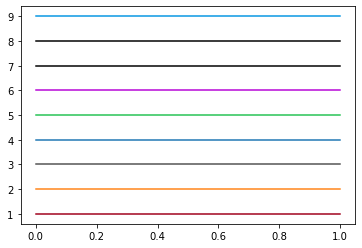

In [4]:
plt.plot([0,1], [1,1], color=colormap["houseprice"])
plt.plot([0,1], [2,2], color=colormap["gold"])
plt.plot([0,1], [3,3], color=colormap["oil"])
plt.plot([0,1], [4,4], color=colormap["sp500"])
plt.plot([0,1], [5,5], color=colormap["inflation"])
plt.plot([0,1], [6,6], color=colormap["effective"])
plt.plot([0,1], [7,7], color=colormap["upper"])
plt.plot([0,1], [8,8], color=colormap["lower"])
plt.plot([0,1], [9,9], color=colormap["target"])


### House Price Data

The house prices contains the data which will be used as a target value for the regression. The dataset is available at https://datahub.io/core/house-prices-us . The default target value is the overall house price estimation of all United States District namely "National-US". This value can be changed by changing the selector for the dataset while merging the data

In [5]:
pdHouseprices = pd.read_csv("../datasets/houseprices.csv")
pdHouseprices["Date"] = pd.to_datetime(pdHouseprices["Date"])
pdHouseprices

,Date,AZ-Phoenix,CA-Los Angeles,CA-San Diego,CA-San Francisco,CO-Denver,DC-Washington,FL-Miami,FL-Tampa,GA-Atlanta,...,NC-Charlotte,NV-Las Vegas,NY-New York,OH-Cleveland,OR-Portland,TX-Dallas,WA-Seattle,Composite-10,Composite-20,National-US
0,1987-01-01,NaN,59.33,54.67,46.61,50.20,64.11,68.50,77.33,NaN,...,63.39,66.36,74.42,53.53,41.05,NaN,NaN,62.82,NaN,63.75
1,1987-02-01,NaN,59.65,54.89,46.87,49.96,64.77,68.76,77.93,NaN,...,63.94,67.03,75.43,53.50,41.28,NaN,NaN,63.39,NaN,64.15
2,1987-03-01,NaN,59.99,55.16,47.32,50.15,65.71,69.23,77.76,NaN,...,64.17,67.34,76.25,53.68,41.06,NaN,NaN,63.87,NaN,64.49
3,1987-04-01,NaN,60.81,55.85,47.69,50.55,66.40,69.20,77.56,NaN,...,64.81,67.88,77.34,53.75,40.96,NaN,NaN,64.57,NaN,64.99
4,1987-05-01,NaN,61.67,56.35,48.31,50.63,67.27,69.46,77.85,NaN,...,65.18,67.90,79.16,54.71,41.24,NaN,NaN,65.56,NaN,65.57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,2015-08-01,154.82,238.27,215.22,215.14,172.78,212.88,201.95,172.11,126.21,...,134.37,144.88,181.66,109.83,186.51,154.67,183.83,197.20,182.34,175.17
344,2015-09-01,155.15,238.68,216.37,216.34,173.48,211.88,203.78,172.95,126.33,...,134.20,144.96,181.66,109.45,187.98,155.28,184.25,197.40,182.58,175.32
345,2015-10-01,155.92,238.91,215.62,217.83,174.21,210.77,205.09,174.08,126.03,...,134.51,144.89,181.40,108.74,188.88,155.83,185.16,197.32,182.61,175.40
346,2015-11-01,156.42,239.67,216.54,218.42,174.42,210.52,206.68,174.96,125.69,...,134.97,144.77,180.96,108.82,189.47,156.14,186.05,197.32,182.71,175.50


In [6]:
housePriceSelector = "National-US"
housePriceSelectorName = "Case-Shiller-Index (National US)"

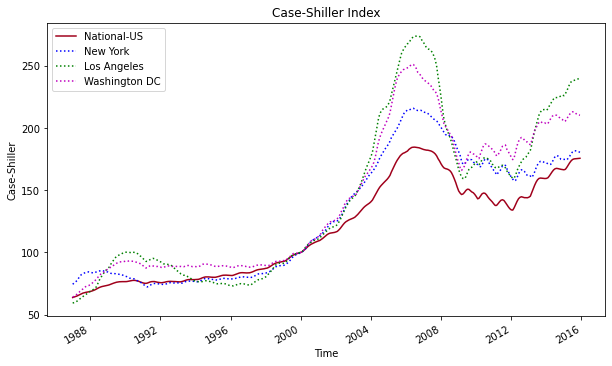

In [7]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(pdHouseprices["Date"], pdHouseprices[housePriceSelector], "r-", label=housePriceSelector,color=colormap["houseprice"])
ax.plot(pdHouseprices["Date"], pdHouseprices["NY-New York"], "b:", label="New York")
ax.plot(pdHouseprices["Date"], pdHouseprices["CA-Los Angeles"], "g:", label="Los Angeles")
ax.plot(pdHouseprices["Date"], pdHouseprices["DC-Washington"], "m:", label="Washington DC")

fig.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.set_title('Case-Shiller Index')
ax.legend()
plt.ylabel('Case-Shiller')
plt.xlabel('Time')
plt.show()

### S&P 500
The SP500 is a stock market index which is considered to be important in the United States of America. Besides the Stock Market index value it contains a Real Price Value which can be used to calculate the inflation rate coresponding to the last given timepoint of this timeseries. The dataset is available at https://datahub.io/core/s-and-p-500

In [8]:
pdSP500 = pd.read_csv("../datasets/sp500.csv")
pdSP500["Date"] = pd.to_datetime(pdSP500["Date"])
pdSP500["SP500 nom"] = pdSP500["Real Price"]# rename 
pdSP500["factor"] = pdSP500["Real Price"]/pdSP500["SP500"] # calculate inflation factor
pdSP500

,Date,SP500,Dividend,Earnings,Consumer Price Index,Long Interest Rate,Real Price,Real Dividend,Real Earnings,PE10,SP500 nom,factor
0,1871-01-01,4.44,0.26,0.40,12.46,5.32,89.00,5.21,8.02,NaN,89.00,20.045045
1,1871-02-01,4.50,0.26,0.40,12.84,5.32,87.53,5.06,7.78,NaN,87.53,19.451111
2,1871-03-01,4.61,0.26,0.40,13.03,5.33,88.36,4.98,7.67,NaN,88.36,19.167028
3,1871-04-01,4.74,0.26,0.40,12.56,5.33,94.29,5.17,7.96,NaN,94.29,19.892405
4,1871-05-01,4.86,0.26,0.40,12.27,5.33,98.93,5.29,8.14,NaN,98.93,20.355967
...,...,...,...,...,...,...,...,...,...,...,...,...
1763,2017-12-01,2664.34,48.93,109.88,246.52,2.40,2700.13,49.59,111.36,32.09,2700.13,1.013433
1764,2018-01-01,2789.80,49.29,NaN,247.87,2.58,2811.96,49.68,NaN,33.31,2811.96,1.007943
1765,2018-02-01,2705.16,49.64,NaN,248.99,2.86,2714.34,49.81,NaN,32.12,2714.34,1.003394
1766,2018-03-01,2702.77,50.00,NaN,249.55,2.84,2705.82,50.06,NaN,31.99,2705.82,1.001128


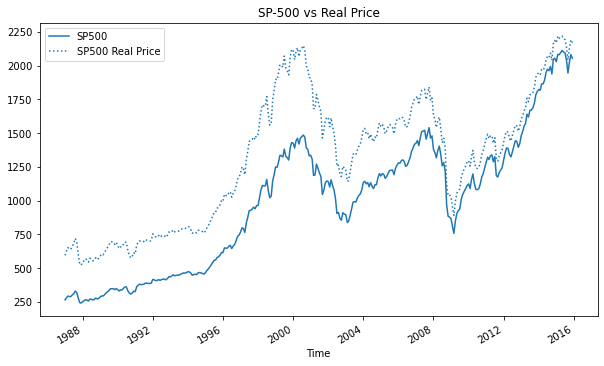

In [9]:
mskSP500 = (pdSP500["Date"] >=  "1987-01-01") & (pdSP500["Date"] <= "2015-12-01")
scaling_sp = pdHouseprices.max()[housePriceSelector]/pdSP500.loc[mskSP500].max()["SP500"]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(pdHouseprices["Date"], pdSP500.loc[mskSP500]["SP500"], "g-", label="SP500",color=colormap["sp500"])
ax.plot(pdHouseprices["Date"], pdSP500.loc[mskSP500]["Real Price"], "m:", label="SP500 Real Price",color=colormap["sp500"])

fig.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.set_title('SP-500 vs Real Price')
ax.legend()
plt.ylabel('')
plt.xlabel('Time')
plt.show()

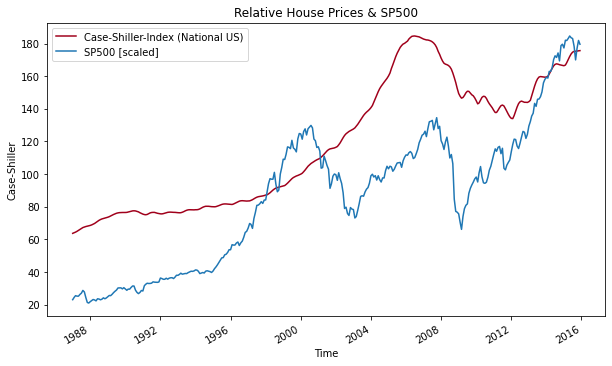

In [10]:
mskSP500 = (pdSP500["Date"] >=  "1987-01-01") & (pdSP500["Date"] <= "2015-12-01")
scaling_sp = pdHouseprices.max()[housePriceSelector]/pdSP500.loc[mskSP500].max()["SP500"]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(pdHouseprices["Date"],  pdHouseprices[housePriceSelector], "r-", label=housePriceSelectorName,color=colormap["houseprice"])
ax.plot(pdHouseprices["Date"], [val* scaling_sp for val in pdSP500.loc[mskSP500]["SP500"]], "g-", label="SP500 [scaled]",color=colormap["sp500"])

fig.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.set_title('Relative House Prices & SP500')
ax.legend()
plt.ylabel('Case-Shiller')
plt.xlabel('Time')
plt.show()

In [11]:
pdHouseprices[housePriceSelector +" nom"] = pdHouseprices[housePriceSelector].reset_index(drop=True)*pdSP500[mskSP500]["factor"].reset_index(drop=True)
pdHouseprices

,Date,AZ-Phoenix,CA-Los Angeles,CA-San Diego,CA-San Francisco,CO-Denver,DC-Washington,FL-Miami,FL-Tampa,GA-Atlanta,...,NV-Las Vegas,NY-New York,OH-Cleveland,OR-Portland,TX-Dallas,WA-Seattle,Composite-10,Composite-20,National-US,National-US nom
0,1987-01-01,NaN,59.33,54.67,46.61,50.20,64.11,68.50,77.33,NaN,...,66.36,74.42,53.53,41.05,NaN,NaN,62.82,NaN,63.75,143.229017
1,1987-02-01,NaN,59.65,54.89,46.87,49.96,64.77,68.76,77.93,NaN,...,67.03,75.43,53.50,41.28,NaN,NaN,63.39,NaN,64.15,143.610132
2,1987-03-01,NaN,59.99,55.16,47.32,50.15,65.71,69.23,77.76,NaN,...,67.34,76.25,53.68,41.06,NaN,NaN,63.87,NaN,64.49,143.727816
3,1987-04-01,NaN,60.81,55.85,47.69,50.55,66.40,69.20,77.56,NaN,...,67.88,77.34,53.75,40.96,NaN,NaN,64.57,NaN,64.99,144.072025
4,1987-05-01,NaN,61.67,56.35,48.31,50.63,67.27,69.46,77.85,NaN,...,67.90,79.16,54.71,41.24,NaN,NaN,65.56,NaN,65.57,144.843699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,2015-08-01,154.82,238.27,215.22,215.14,172.78,212.88,201.95,172.11,126.21,...,144.88,181.66,109.83,186.51,154.67,183.83,197.20,182.34,175.17,183.637090
344,2015-09-01,155.15,238.68,216.37,216.34,173.48,211.88,203.78,172.95,126.33,...,144.96,181.66,109.45,187.98,155.28,184.25,197.40,182.58,175.32,184.081447
345,2015-10-01,155.92,238.91,215.62,217.83,174.21,210.77,205.09,174.08,126.03,...,144.89,181.40,108.74,188.88,155.83,185.16,197.32,182.61,175.40,184.247920
346,2015-11-01,156.42,239.67,216.54,218.42,174.42,210.52,206.68,174.96,125.69,...,144.77,180.96,108.82,189.47,156.14,186.05,197.32,182.71,175.50,184.743057


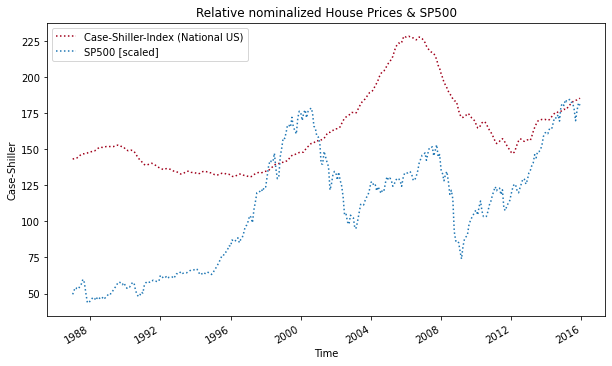

In [12]:
mskSP500 = (pdSP500["Date"] >=  "1987-01-01") & (pdSP500["Date"] <= "2015-12-01")
scaling_sp = pdHouseprices.max()[housePriceSelector]/pdSP500.loc[mskSP500].max()["Real Price"]


fig, ax = plt.subplots(figsize=(10,6))
ax.plot(pdHouseprices["Date"],  pdHouseprices[housePriceSelector].reset_index(drop=True)*pdSP500[mskSP500]["factor"].reset_index(drop=True), "r:", label=housePriceSelectorName,color=colormap["houseprice"])
ax.plot(pdHouseprices["Date"], [val* scaling_sp for val in pdSP500.loc[mskSP500]["Real Price"]], "g:", label="SP500 [scaled]",color=colormap["sp500"])

fig.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.set_title('Relative nominalized House Prices & SP500')
ax.legend()
plt.ylabel('Case-Shiller')
plt.xlabel('Time')
plt.show()

### Gold Price

The goldprice dataset is available at https://datahub.io/core/gold-prices

In [13]:
pdGoldprice = pd.read_csv("../datasets/gold_monthly.csv")
pdGoldprice["Date"] = pd.to_datetime(pdGoldprice["Date"])
pdGoldprice

,Date,Price
0,1950-01-01,34.730
1,1950-02-01,34.730
2,1950-03-01,34.730
3,1950-04-01,34.730
4,1950-05-01,34.730
...,...,...
839,2019-12-01,1480.025
840,2020-01-01,1560.668
841,2020-02-01,1598.818
842,2020-03-01,1593.764


In [14]:
mskSP500 = (pdSP500["Date"] >=  "1950-01-01") & (pdSP500["Date"] <= "2018-04-01")
mskGoldprice = (pdGoldprice["Date"] >=  "1950-01-01") & (pdGoldprice["Date"] <= "2018-04-01")

pdGoldprice = pdGoldprice[mskGoldprice].copy()
pdGoldprice["Price nom"] = pdGoldprice["Price"].reset_index(drop=True)*pdSP500[mskSP500]["factor"].reset_index(drop=True)
pdGoldprice

,Date,Price,Price nom
0,1950-01-01,34.730,369.232571
1,1950-02-01,34.730,369.215619
2,1950-03-01,34.730,367.657585
3,1950-04-01,34.730,367.662993
4,1950-05-01,34.730,366.115222
...,...,...,...
815,2017-12-01,1265.674,1282.675761
816,2018-01-01,1332.809,1343.395797
817,2018-02-01,1333.775,1338.301185
818,2018-03-01,1325.562,1327.057859


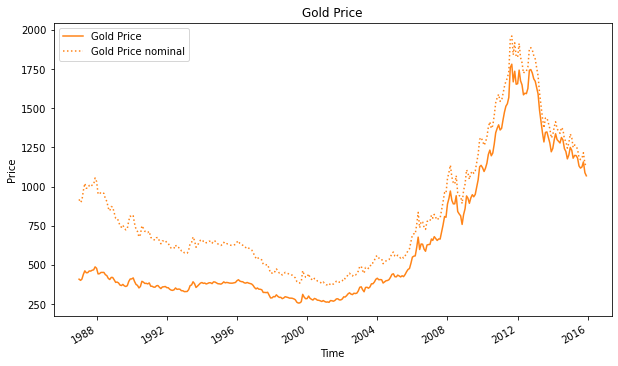

In [15]:
mskGoldprice = (pdGoldprice["Date"] >=  "1987-01-01") & (pdGoldprice["Date"] <= "2015-12-01")
scaling = pdGoldprice.loc[mskGoldprice].max()["Price"]/pdHouseprices.max()[housePriceSelector]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(pdHouseprices["Date"], pdGoldprice.loc[mskGoldprice]["Price"], "b-", label="Gold Price",color=colormap["gold"])
ax.plot(pdHouseprices["Date"], pdGoldprice.loc[mskGoldprice]["Price nom"], "m:", label="Gold Price nominal",color=colormap["gold"])
fig.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.set_title('Gold Price')
ax.legend()
plt.ylabel('Price')
plt.xlabel('Time')
plt.show()

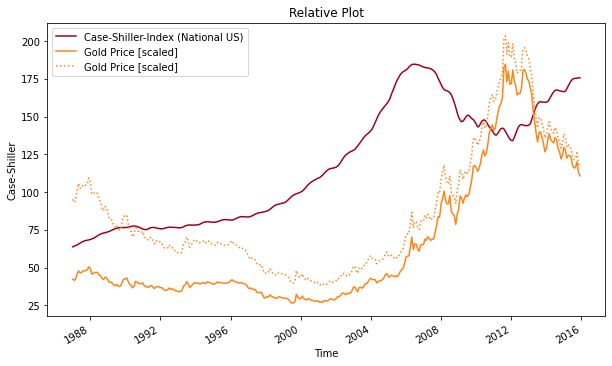

In [16]:
mskGoldprice = (pdGoldprice["Date"] >=  "1987-01-01") & (pdGoldprice["Date"] <= "2015-12-01")
scaling = pdGoldprice.loc[mskGoldprice].max()["Price"]/pdHouseprices.max()[housePriceSelector]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(pdHouseprices["Date"], pdHouseprices[housePriceSelector], "r-", label=housePriceSelectorName,color=colormap["houseprice"])
ax.plot(pdHouseprices["Date"], [(1/scaling)*g for g in pdGoldprice.loc[mskGoldprice]["Price"]], "-", label="Gold Price" +" [scaled]",color=colormap["gold"])
ax.plot(pdHouseprices["Date"], [(1/scaling)*g for g in pdGoldprice.loc[mskGoldprice]["Price nom"]], ":", label="Gold Price" +" [scaled]",color=colormap["gold"])
fig.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.set_title('Relative Plot')
ax.legend()
plt.ylabel('Case-Shiller')
plt.xlabel('Time')
plt.show()

### Oil Price

The oil price is given every month but not for the 01th but for the 15th day of this month. to get the same time stamp as for other datasets there are several possible ways to deal with that. One way is to use interpolate the point by using consecutive dataopoints and interpolate the missing one. Currently the for simplicity the datapoint which is following the date is used so that the dates are only translated. https://datahub.io/core/oil-prices

In [17]:
# todo other interpolation methods?
from datetime import timedelta
pdOilprice = pd.read_csv("../datasets/wti_month.csv")
pdOilprice["Date"] = pd.to_datetime(pdOilprice["Date"]) - timedelta(days=14) # transform the day 

pdOilprice

,Date,Price
0,1986-01-01,22.93
1,1986-02-01,15.46
2,1986-03-01,12.61
3,1986-04-01,12.84
4,1986-05-01,15.38
...,...,...
408,2020-01-01,57.52
409,2020-02-01,50.54
410,2020-03-01,29.21
411,2020-04-01,16.55


In [18]:
mskSP500 = (pdSP500["Date"] >=  "1986-01-01") & (pdSP500["Date"] <= "2018-04-01")
mskOilprice = (pdOilprice["Date"] >=  "1986-01-01") & (pdOilprice["Date"] <= "2018-04-01")

pdOilprice = pdOilprice[mskOilprice].copy()
pdOilprice
pdOilprice["Price nom"] = pdOilprice["Price"].reset_index(drop=True)*pdSP500[mskSP500]["factor"].reset_index(drop=True)
pdOilprice
#pdGoldprice[mskGoldprice]["P"] = val

,Date,Price,Price nom
0,1986-01-01,22.93,52.269827
1,1986-02-01,15.46,35.338149
2,1986-03-01,12.61,28.956316
3,1986-04-01,12.84,29.538474
4,1986-05-01,15.38,35.284364
...,...,...,...
383,2017-12-01,57.88,58.657500
384,2018-01-01,63.70,64.205983
385,2018-02-01,62.23,62.441178
386,2018-03-01,62.73,62.800789


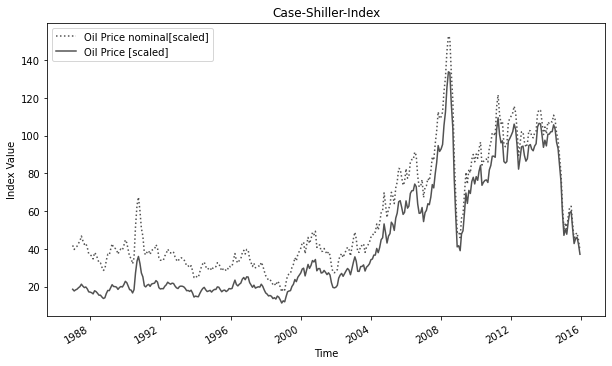

In [19]:
maskOilPrice = (pdOilprice["Date"] >=  "1987-01-01") & (pdOilprice["Date"] <= "2015-12-01")
mskGoldmask = (pdGoldprice["Date"] >=  "1987-01-01") & (pdGoldprice["Date"] <= "2015-12-01")

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(pdHouseprices["Date"], pdOilprice.loc[maskOilPrice]["Price nom"], "m:", label="Oil Price nominal[scaled]",color=colormap["oil"])
ax.plot(pdHouseprices["Date"], pdOilprice.loc[maskOilPrice]["Price"], "k-", label="Oil Price [scaled]",color=colormap["oil"])
#ax.plot(pdHouseprices["Date"], [val * scaling_gold for val in pdGoldprice.loc[mskGoldmask]["Price"]], "b:", label="Gold Price [scaled]")

fig.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.set_title('Case-Shiller-Index')
ax.legend()
plt.ylabel('Index Value')
plt.xlabel('Time')
plt.show()

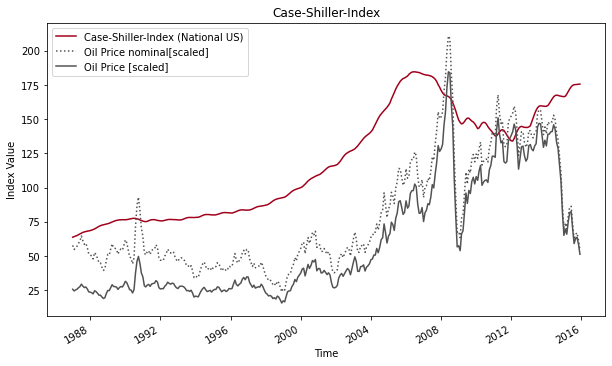

In [20]:
maskOilPrice = (pdOilprice["Date"] >=  "1987-01-01") & (pdOilprice["Date"] <= "2015-12-01")
mskGoldmask = (pdGoldprice["Date"] >=  "1987-01-01") & (pdGoldprice["Date"] <= "2015-12-01")

scaling_gold = pdHouseprices.max()[housePriceSelector]/pdGoldprice.loc[mskGoldprice].max()["Price"]
scaling_oil = pdHouseprices.max()[housePriceSelector]/pdOilprice.loc[maskOilPrice].max()["Price"]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(pdHouseprices["Date"],  pdHouseprices[housePriceSelector], "r-", label=housePriceSelectorName,color=colormap["houseprice"])
ax.plot(pdHouseprices["Date"], [val* scaling_oil for val in pdOilprice.loc[maskOilPrice]["Price nom"]], "m:", label="Oil Price nominal[scaled]",color=colormap["oil"])
ax.plot(pdHouseprices["Date"], [val* scaling_oil for val in pdOilprice.loc[maskOilPrice]["Price"]], "k-", label="Oil Price [scaled]",color=colormap["oil"])
#ax.plot(pdHouseprices["Date"], [val * scaling_gold for val in pdGoldprice.loc[mskGoldmask]["Price"]], "b:", label="Gold Price [scaled]")

fig.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.set_title('Case-Shiller-Index')
ax.legend()
plt.ylabel('Index Value')
plt.xlabel('Time')
plt.show()

### Federal Funds Rate, GDP, Unemployment, Inflation

https://www.kaggle.com/federalreserve/interest-rates

In [21]:
pdFED = pd.read_csv("../datasets/fed_rates.csv")
pdFED["Date"] = pd.to_datetime(pdFED["Year"]*10000+pdFED["Month"]*100+pdFED["Day"],format='%Y%m%d')
pdFED.tail()

,Year,Month,Day,Federal Funds Target Rate,Federal Funds Upper Target,Federal Funds Lower Target,Effective Federal Funds Rate,Real GDP (Percent Change),Unemployment Rate,Inflation Rate,Date
899,2016,12,14,NaN,0.75,0.50,NaN,NaN,NaN,NaN,2016-12-14
900,2017,1,1,NaN,0.75,0.50,0.65,NaN,4.8,2.3,2017-01-01
901,2017,2,1,NaN,0.75,0.50,0.66,NaN,4.7,2.2,2017-02-01
902,2017,3,1,NaN,0.75,0.50,NaN,NaN,NaN,NaN,2017-03-01
903,2017,3,16,NaN,1.00,0.75,NaN,NaN,NaN,NaN,2017-03-16


The target rate was used until the financial crisis, after that this was replaced by a upper and lower target rate. Which were not present before this date. To approximate the targetrate this can be calculated as a value between the given boundaries. To get an adequate value this is choosen as the arithmetic mean of the boundaries. However the effective Rate will be used in the model

In [22]:
pdFEDmask = (pdFED["Date"] >=  "1987-01-01") & (pdFED["Date"] <= "2015-12-01")

pdFED.loc[pdFEDmask & ( pdFED["Federal Funds Target Rate"].isna()),"Federal Funds Target Rate"] = 1/2*(pdFED.loc[pdFEDmask & ( pdFED["Federal Funds Target Rate"].isna())]["Federal Funds Upper Target"]  + pdFED.loc[pdFEDmask & ( pdFED["Federal Funds Target Rate"].isna())]["Federal Funds Lower Target"])
pdFED.tail()

,Year,Month,Day,Federal Funds Target Rate,Federal Funds Upper Target,Federal Funds Lower Target,Effective Federal Funds Rate,Real GDP (Percent Change),Unemployment Rate,Inflation Rate,Date
899,2016,12,14,NaN,0.75,0.50,NaN,NaN,NaN,NaN,2016-12-14
900,2017,1,1,NaN,0.75,0.50,0.65,NaN,4.8,2.3,2017-01-01
901,2017,2,1,NaN,0.75,0.50,0.66,NaN,4.7,2.2,2017-02-01
902,2017,3,1,NaN,0.75,0.50,NaN,NaN,NaN,NaN,2017-03-01
903,2017,3,16,NaN,1.00,0.75,NaN,NaN,NaN,NaN,2017-03-16


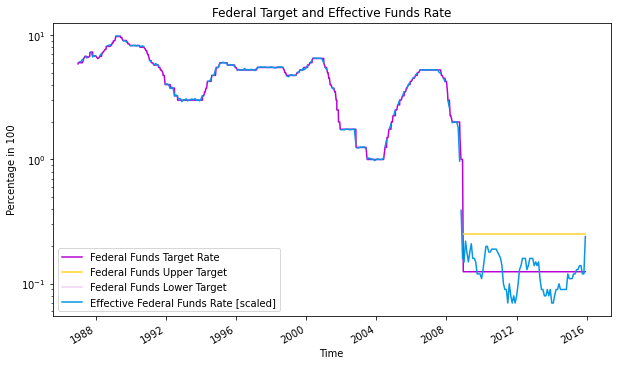

In [23]:
pdFEDmask = (pdFED["Date"] >=  "1987-01-01") & (pdFED["Date"] <= "2015-12-01")

fig, ax = plt.subplots(figsize=(10,6))
#ax.plot(pdHouseprices["Date"],  pdHouseprices["National-US"], "r-", label=housePriceSelectorName, color="#0EF05E")
ax.semilogy(pdFED.loc[pdFEDmask]["Date"], [val for val in pdFED.loc[pdFEDmask]["Federal Funds Target Rate"]], "y-", label="Federal Funds Target Rate",color="#B704D6")
ax.semilogy(pdFED.loc[pdFEDmask]["Date"], [val for val in pdFED.loc[pdFEDmask]["Federal Funds Upper Target"]], "m-", label="Federal Funds Upper Target", color="#FFD123")
ax.semilogy(pdFED.loc[pdFEDmask]["Date"], [val for val in pdFED.loc[pdFEDmask]["Federal Funds Lower Target"]], "m-", label="Federal Funds Lower Target", color="#F0D1F3")
ax.semilogy(pdFED.loc[pdFEDmask]["Date"], [val for val in pdFED.loc[pdFEDmask]["Effective Federal Funds Rate"]], "-", label="Effective Federal Funds Rate [scaled]", color="#0797E3")

fig.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.set_title('Federal Target and Effective Funds Rate')
ax.legend()
plt.ylabel('Percentage in 100')
plt.xlabel('Time')
plt.show()

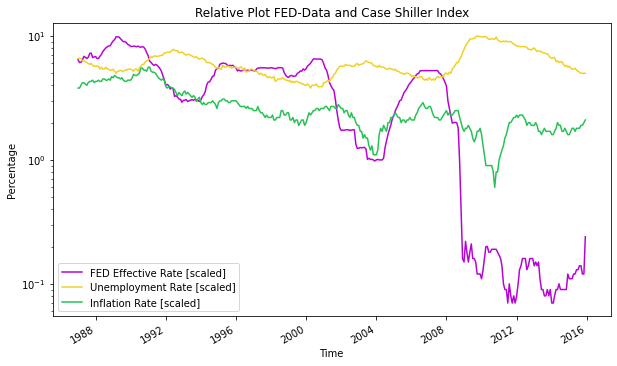

In [24]:
pdFEDmask = (pdFED["Date"] >=  "1987-01-01") & (pdFED["Date"] <= "2015-12-01")

#scaling_fed_effr = pdHouseprices.max()[housePriceSelector]/pdFED.loc[pdFEDmask].max()["Effective Federal Funds Rate"]

#scaling_fed_effr  =1 
fig, ax = plt.subplots(figsize=(10,6))
#ax.plot(pdHouseprices["Date"],  pdHouseprices[housePriceSelector], "r-", label=housePriceSelectorName,color=colormap["houseprice"])
ax.semilogy(pdFED.loc[pdFEDmask & pdFED["Effective Federal Funds Rate"].notnull()]["Date"], [val for val in pdFED.loc[pdFEDmask&pdFED["Effective Federal Funds Rate"].notnull()]["Effective Federal Funds Rate"]], "y-", label="FED Effective Rate [scaled]",color=colormap["effective"])
ax.semilogy(pdFED.loc[pdFEDmask & pdFED["Unemployment Rate"].notnull()]["Date"], [val for val in pdFED.loc[pdFEDmask&pdFED["Unemployment Rate"].notnull()]["Unemployment Rate"]], "m-", label="Unemployment Rate [scaled]", color=colormap["unemployment"])
ax.semilogy(pdFED.loc[pdFEDmask & pdFED["Inflation Rate"].notnull()]["Date"], [val for val in pdFED.loc[pdFEDmask&pdFED["Inflation Rate"].notnull()]["Inflation Rate"]], "-", label="Inflation Rate [scaled]", color=colormap["inflation"])

fig.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.set_title('Relative Plot FED-Data and Case Shiller Index')
ax.legend()
plt.ylabel('Percentage')
plt.xlabel('Time')
plt.show()

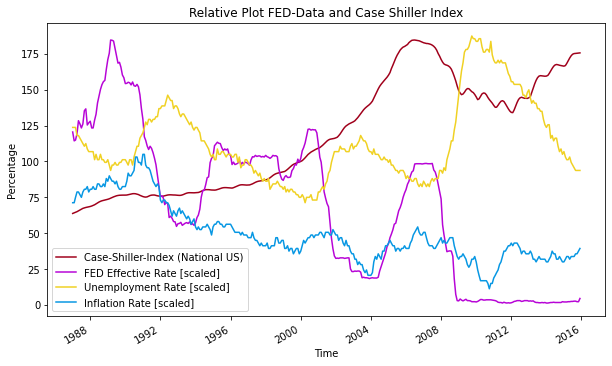

In [25]:
pdFEDmask = (pdFED["Date"] >=  "1987-01-01") & (pdFED["Date"] <= "2015-12-01")

scaling_fed_effr = pdHouseprices.max()[housePriceSelector]/pdFED.loc[pdFEDmask].max()["Effective Federal Funds Rate"]

#scaling_fed_effr  =1 
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(pdHouseprices["Date"],  pdHouseprices[housePriceSelector], "r-", label=housePriceSelectorName,color=colormap["houseprice"])
ax.plot(pdFED.loc[pdFEDmask & pdFED["Effective Federal Funds Rate"].notnull()]["Date"], [val*scaling_fed_effr for val in pdFED.loc[pdFEDmask&pdFED["Effective Federal Funds Rate"].notnull()]["Effective Federal Funds Rate"]], "y-", label="FED Effective Rate [scaled]",color="#B704D6")
ax.plot(pdFED.loc[pdFEDmask & pdFED["Unemployment Rate"].notnull()]["Date"], [val*scaling_fed_effr for val in pdFED.loc[pdFEDmask&pdFED["Unemployment Rate"].notnull()]["Unemployment Rate"]], "m-", label="Unemployment Rate [scaled]", color="#F0D123")
ax.plot(pdFED.loc[pdFEDmask & pdFED["Inflation Rate"].notnull()]["Date"], [val*scaling_fed_effr for val in pdFED.loc[pdFEDmask&pdFED["Inflation Rate"].notnull()]["Inflation Rate"]], "-", label="Inflation Rate [scaled]", color="#0797E3")

fig.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.set_title('Relative Plot FED-Data and Case Shiller Index')
ax.legend()
plt.ylabel('Percentage')
plt.xlabel('Time')
plt.show()

## Merging Data
Most datasets are given in a monthly period so the first step is to find the biggest time interval which all datasets have in common. Missing values in between of the start and the endpoint will still be used, so that only the overall interval will be estimated.
From experience and the economical theory prices does not depend on the data of a single timestamp only but on a small time window in which the prices develop. Therefore two different approches are considered. 

* The first approch is to collect the data for every additional timestamp. For instance with a time window of k=3 the prices of the timestamp t, t-1 and t-2 will be filled into a table. By this approch the number of features will be increased but most features are highly correlated. For simplicity instead of t-k the value is denoted as tk
* The second approch is to apply a convolution so that every value of this time window will be weighted an sum up. The number of features will be the same as without using the time window approach but the data will be enrichted and some pertubence will be damped. 

From graphes there is an exponential relationship expected so that applying the logarithm on all adequat values can transform the realationship into a linear relationship.

In [26]:
import functools

def largest(source, target):
    """
        extends the time interval of both dataset so that they have same start and end date. The missing valuse are only filled with NaN values
    """
    source_lower = source[0]
    source_upper = source[len(source)-1]
    target_lower = target[0]
    target_upper = target[len(target) -1 ]
    lower = source_lower if source_lower < target_lower else target_lower
    upper = source_upper if source_upper > target_upper else target_upper
    return (lower, upper)

def smallest(source, target):
    """
        finds the time period of two datasets which they have in common
    """
    source_lower = source[0]
    source_upper = source[len(source)-1]
    target_lower = target[0]
    target_upper = target[len(target) -1 ]
    lower = source_lower if source_lower > target_lower else target_lower
    upper = source_upper if source_upper < target_upper else target_upper
    return (lower, upper)

def expand(source , lower, upper):
    print("func.expand")
    return (lower,upper,target_lower, target_upper)

def shrink(source , lower, upper):
    mask = (source["Date"] >=  lower) & (source["Date"] <= upper)
    return  source.loc[mask]
   
def ttype(a,b):
    print("func.ttypes")
    print(type(a), type(b[0]))
    
def copyDataFrame(a,b,targetname, selection):
    b.index = a.index
    a[["Date", targetname]] = b[["Date", selection]]

#smallest(pdgoldprice["Date"], sp500["Date"])
dateframe = [pdGoldprice["Date"],
             pdSP500["Date"], 
             pdFED["Date"], 
             pdHouseprices["Date"], 
             #gasprice["Date"], 
             pdOilprice["Date"]]
lower, upper = functools.reduce(smallest, dateframe)
print("lagest time range that all datasets have in common is \n",functools.reduce(largest, dateframe))

lagest time range that all datasets have in common is 
 (Timestamp('1871-01-01 00:00:00'), Timestamp('2018-04-01 00:00:00'))


Time window approch. The size of the time window can be controlled by the value iConvolve. It has to be at least 1. By setting this value ot 1 only one value will be used. It could also be interesting to change the overall timewindow so that every feature has its own window size.

In [27]:
from datetime import datetime, timedelta
from dateutil.relativedelta import *

if useNominalValues:
    useNomValues = " nom" # or "" else
else:
    useNomValues = ""
    
pdMerged = shrink(pdHouseprices,lower,upper)[["Date",housePriceSelector +useNomValues]].copy()
pdMerged[housePriceSelector+useNomValues] = pdMerged[housePriceSelector+useNomValues]


for i in range(iConvolve):
    nlower = lower + relativedelta(months=-i)
    nupper = upper + relativedelta(months=-i)
    tmpGoldprice = shrink(pdGoldprice, nlower, nupper)
    copyDataFrame(pdMerged, tmpGoldprice, "Gold Price t"+str(i),"Price"+ useNomValues)

for i in range(iConvolve):
    nlower = lower + relativedelta(months=-i)
    nupper = upper + relativedelta(months=-i)
    tmpSP500 = shrink(pdSP500, nlower, nupper)
    copyDataFrame(pdMerged, tmpSP500, "SP500 t"+str(i),"SP500"+ useNomValues)

for i in range(iConvolve):
    nlower = lower + relativedelta(months=-i)
    nupper = upper + relativedelta(months=-i)
    tmpOilprice = shrink(pdOilprice, nlower, nupper)
    copyDataFrame(pdMerged, tmpOilprice, "Oil Price t"+str(i), "Price" +useNomValues)

for i in range(iConvolve):
    nlower = lower + relativedelta(months=-i)
    nupper = upper + relativedelta(months=-i)
    tmpFED = shrink(pdFED, nlower, nupper).copy()
    indexname = tmpFED[tmpFED["Day"] != 1].index
    tmpFED.drop(indexname, inplace=True)
    copyDataFrame(pdMerged, tmpFED, "FED Effective Rate t"+str(i), "Effective Federal Funds Rate")
    #copyDataFrame(pdMerged, tmpFED, "FED Target Rate t"+str(i), "Federal Funds Target Rate")
    copyDataFrame(pdMerged, tmpFED, "GDP t"+str(i), "Real GDP (Percent Change)")
    copyDataFrame(pdMerged, tmpFED, "Unemployment t"+str(i), "Unemployment Rate")
    copyDataFrame(pdMerged, tmpFED, "Inflation Rate t"+str(i), "Inflation Rate")

In [28]:
pdMerged.head()

,Date,National-US,Gold Price t0,Gold Price t1,Gold Price t2,Gold Price t3,SP500 t0,SP500 t1,SP500 t2,SP500 t3,...,Unemployment t1,Inflation Rate t1,FED Effective Rate t2,GDP t2,Unemployment t2,Inflation Rate t2,FED Effective Rate t3,GDP t3,Unemployment t3,Inflation Rate t3
0,1986-10-01,63.75,408.524,391.595,396.983,423.863,264.5,248.6,245.1,237.4,...,6.6,3.8,6.04,NaN,6.9,3.8,5.85,2.1,7.0,4.0
1,1986-11-01,64.15,401.045,408.524,391.595,396.983,280.9,264.5,248.6,245.1,...,6.6,3.8,6.91,NaN,6.6,3.8,6.04,NaN,6.9,3.8
2,1986-12-01,64.49,408.848,401.045,408.524,391.595,292.5,280.9,264.5,248.6,...,6.6,3.8,6.43,2.8,6.6,3.8,6.91,NaN,6.6,3.8
3,1987-01-01,64.99,439.665,408.848,401.045,408.524,289.3,292.5,280.9,264.5,...,6.6,4.0,6.10,NaN,6.6,3.8,6.43,2.8,6.6,3.8
4,1987-02-01,65.57,461.650,439.665,408.848,401.045,289.1,289.3,292.5,280.9,...,6.3,4.2,6.13,NaN,6.6,4.0,6.10,NaN,6.6,3.8


The "function" is the weighting function that will be applied for the convolution and can be changed to get a different weighting of the data. To tread nan values the missing values are filled with the standard fill method which propagates of timepoiints where valid data exists. For the gdp and the interest rates this is valid because there is a periodicity in which datapoints are provided. 

In [29]:
# apply averageolution
from math import exp,sqrt
def function(k):
    return exp(-k/4)

"""
def function(k):
    return 1.0/sqrt(k+1)
"""

adaption = function(0)
pdConvolutionDecay = pd.DataFrame(pdMerged[["Date",housePriceSelector + useNomValues]].copy().to_numpy(),columns=["Date",housePriceSelector + useNomValues])
pdConvolutionDecay["Gold Price"] = function(0)*pdMerged["Gold Price t"+str(0)]
pdConvolutionDecay["SP500"] = function(0)*pdMerged["SP500 t"+str(0)]
pdConvolutionDecay["Oil Price"] = function(0)*pdMerged["Oil Price t"+str(0)]
pdConvolutionDecay["Inflation Rate"] = function(0)*pdMerged["Inflation Rate t"+str(0)]
pdConvolutionDecay["FED Effective Rate"]= function(0)*pdMerged["FED Effective Rate t"+str(0)]
#pdConvolutionDecay["FED Target Rate"] = function(0)*pdMerged["FED Target Rate t"+str(0)].fillna(method='ffill')
pdConvolutionDecay["GDP"] = function(0)*pdMerged["GDP t"+str(0)].fillna(method='ffill')
pdConvolutionDecay["Unemployment"] = function(0)*pdMerged["Unemployment t"+str(0)]

for i in range(1, iConvolve):
    pdConvolutionDecay["Gold Price"] = pdConvolutionDecay["Gold Price"] + function(i)*pdMerged["Gold Price t"+str(i)]
    pdConvolutionDecay["SP500"] = pdConvolutionDecay["SP500"] + function(i)*pdMerged["SP500 t"+str(i)]
    pdConvolutionDecay["Oil Price"] = pdConvolutionDecay["Oil Price"] + function(i)*pdMerged["Oil Price t"+str(i)]
    pdConvolutionDecay["Inflation Rate"] = pdConvolutionDecay["Inflation Rate"] + function(i)*pdMerged["Inflation Rate t"+str(i)]
    pdConvolutionDecay["FED Effective Rate"] = pdConvolutionDecay["FED Effective Rate"] + function(i)*pdMerged["FED Effective Rate t"+str(i)]
    #pdConvolutionDecay["FED Target Rate"] = pdConvolutionDecay["FED Target Rate"] + function(i)*pdMerged["FED Target Rate t"+str(i)].fillna(method='ffill')
    pdConvolutionDecay["GDP"] = pdConvolutionDecay["GDP"] + function(i)*pdMerged["GDP t"+str(i)].fillna(0.0)
    pdConvolutionDecay["Unemployment"] = pdConvolutionDecay["Unemployment"] + function(i)*pdMerged["Unemployment t"+str(i)]
    adaption += function(i)


pdConvolutionDecay["Gold Price"] = (1.0/adaption)*pdConvolutionDecay["Gold Price"]
pdConvolutionDecay["SP500"] = (1.0/adaption)*pdConvolutionDecay["SP500"]
pdConvolutionDecay["Oil Price"] = (1.0/adaption)*pdConvolutionDecay["Oil Price"]
pdConvolutionDecay["Inflation Rate"] = (1.0/adaption)*pdConvolutionDecay["Inflation Rate"]
pdConvolutionDecay["FED Effective Rate"] = (1.0/adaption)*pdConvolutionDecay["FED Effective Rate"]
#pdConvolutionDecay["FED Target Rate"] = (1.0/adaption)*pdConvolutionDecay["FED Target Rate"]
pdConvolutionDecay["GDP"] = (1.0/adaption)*pdConvolutionDecay["GDP"]
pdConvolutionDecay["Unemployment"] = (1.0/adaption)*pdConvolutionDecay["Unemployment"]

pdConvolutionDecay.head()

,Date,National-US,Gold Price,SP500,Oil Price,Inflation Rate,FED Effective Rate,GDP,Unemployment
0,1986-10-01,63.75,403.996349,251.569746,16.609921,3.833059,6.382166,1.326932,6.729792
1,1986-11-01,64.15,400.406088,263.657452,17.228994,3.800000,6.351934,1.742886,6.649589
2,1986-12-01,64.49,403.800847,276.139335,17.862397,3.869986,6.314429,1.574094,6.600000
3,1987-01-01,64.99,417.922155,284.289889,18.374093,3.994478,6.257205,2.072517,6.495020
4,1987-02-01,65.57,434.433778,288.520708,18.711570,4.091433,6.442399,2.863313,6.413262


By applying the logarithm the exponential relationship will be transformed into a linear.

In [30]:
pdLogMerged = pdMerged.copy()

pdLogMerged[housePriceSelector+useNomValues] = pdLogMerged[housePriceSelector+useNomValues].apply(np.log)
for i in range(iConvolve):
    pdLogMerged["Gold Price t" +str(i)] = pdLogMerged["Gold Price t"+str(i)].apply(np.log)
    #pdLogMerged["SP500 RP t"+str(i)] = pdLogMerged["SP500 RP t"+str(i)].apply(np.log)
    pdLogMerged["SP500 t"+str(i)] = pdLogMerged["SP500 t"+str(i)].apply(np.log)
    pdLogMerged["Oil Price t"+str(i)] = pdLogMerged["Oil Price t"+str(i)].apply(np.log)

pdLogMerged

,Date,National-US,Gold Price t0,Gold Price t1,Gold Price t2,Gold Price t3,SP500 t0,SP500 t1,SP500 t2,SP500 t3,...,Unemployment t1,Inflation Rate t1,FED Effective Rate t2,GDP t2,Unemployment t2,Inflation Rate t2,FED Effective Rate t3,GDP t3,Unemployment t3,Inflation Rate t3
0,1986-10-01,4.154969,6.012551,5.970228,5.983893,6.049410,5.577841,5.515845,5.501666,5.469746,...,6.6,3.8,6.04,NaN,6.9,3.8,5.85,2.1,7.0,4.0
1,1986-11-01,4.161224,5.994074,6.012551,5.970228,5.983893,5.637999,5.577841,5.515845,5.501666,...,6.6,3.8,6.91,NaN,6.6,3.8,6.04,NaN,6.9,3.8
2,1986-12-01,4.166510,6.013343,5.994074,6.012551,5.970228,5.678465,5.637999,5.577841,5.515845,...,6.6,3.8,6.43,2.8,6.6,3.8,6.91,NaN,6.6,3.8
3,1987-01-01,4.174233,6.086013,6.013343,5.994074,6.012551,5.667464,5.678465,5.637999,5.577841,...,6.6,4.0,6.10,NaN,6.6,3.8,6.43,2.8,6.6,3.8
4,1987-02-01,4.183118,6.134807,6.086013,6.013343,5.994074,5.666773,5.667464,5.678465,5.637999,...,6.3,4.2,6.13,NaN,6.6,4.0,6.10,NaN,6.6,3.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,2015-05-01,5.165757,7.018872,7.031370,7.075173,7.088145,7.620641,7.646898,7.649354,7.655362,...,5.2,1.8,0.13,NaN,5.3,1.8,0.12,NaN,5.5,1.7
344,2015-06-01,5.166613,7.025454,7.018872,7.031370,7.075173,7.572714,7.620641,7.646898,7.649354,...,5.1,1.8,0.13,2.0,5.2,1.8,0.13,NaN,5.3,1.8
345,2015-07-01,5.167069,7.053692,7.025454,7.018872,7.031370,7.613231,7.572714,7.620641,7.646898,...,5.0,1.9,0.14,NaN,5.1,1.8,0.13,2.0,5.2,1.8
346,2015-08-01,5.167639,6.992453,7.053692,7.025454,7.018872,7.640421,7.613231,7.572714,7.620641,...,5.0,1.9,0.14,NaN,5.0,1.9,0.14,NaN,5.1,1.8


In [31]:
pdLogDecayConvolution = pdConvolutionDecay.copy()

pdLogDecayConvolution[housePriceSelector+useNomValues] = pdLogMerged[housePriceSelector+useNomValues]# todo: why not working? pdLogAVGConvolution["NU"].apply(np.log)

pdLogDecayConvolution["Gold Price"] = pdLogDecayConvolution["Gold Price"].apply(np.log)
#pdLogDecayConvolution["SP500 RP"] = pdLogDecayConvolution["SP500"].apply(np.log)
pdLogDecayConvolution["SP500"] = pdLogDecayConvolution["SP500"].apply(np.log)
pdLogDecayConvolution["Oil Price"] = pdLogDecayConvolution["Oil Price"].apply(np.log)

pdLogDecayConvolution

,Date,National-US,Gold Price,SP500,Oil Price,Inflation Rate,FED Effective Rate,GDP,Unemployment
0,1986-10-01,4.154969,6.001406,5.527720,2.810000,3.833059,6.382166,1.326932,6.729792
1,1986-11-01,4.161224,5.992479,5.574651,2.846594,3.800000,6.351934,1.742886,6.649589
2,1986-12-01,4.166510,6.000922,5.620906,2.882698,3.869986,6.314429,1.574094,6.600000
3,1987-01-01,4.174233,6.035295,5.649994,2.910942,3.994478,6.257205,2.072517,6.495020
4,1987-02-01,4.183118,6.074044,5.664767,2.929142,4.091433,6.442399,2.863313,6.413262
...,...,...,...,...,...,...,...,...,...
343,2015-05-01,5.165757,7.046075,7.639731,3.938992,1.783470,0.131846,1.244919,5.235820
344,2015-06-01,5.166613,7.033320,7.614710,3.877212,1.834993,0.136225,1.124353,5.119290
345,2015-07-01,5.167069,7.035019,7.609642,3.830398,1.862246,0.131348,0.645531,5.054284
346,2015-08-01,5.167639,7.020804,7.615675,3.788418,1.918464,0.127551,0.560213,5.016530


### Export as CSV files

Finally after merging and preprocessing of the data all variations of the datasets are stored into comma seperated files

In [32]:
pdMerged.to_csv('../merged/merged.csv',encoding='utf-8',index=False)
pdLogMerged.to_csv('../merged/logmerged.csv',encoding='utf-8',index=False)
pdConvolutionDecay.to_csv('../merged/decayconvolution.csv',encoding='utf-8',index=False)
pdLogDecayConvolution.to_csv('../merged/logavgconvolution.csv',encoding='utf-8',index=False)

## Feature Distribution

After the preparation of the datasets the distribution of the variables within the timeinterval will be observed with histograms. For the 348 rows of the dataset the binsize was choosen to be 30.

In [33]:
displayDataset = pdLogMerged # Non Convolutional dataset
suffix = " t0"

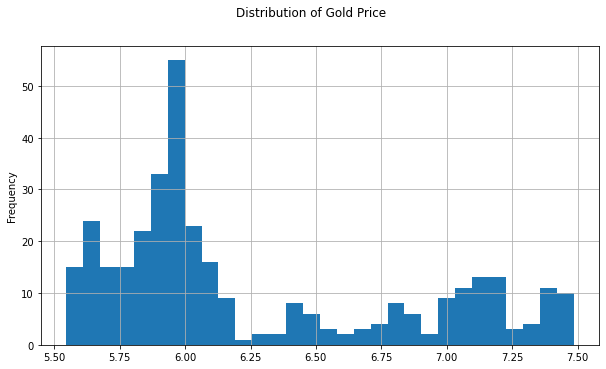

In [34]:
axes = displayDataset["Gold Price"+suffix].plot(kind='hist',bins=30, figsize=(10,5.5),subplots=True,sharex=True,sharey=True,title='Distribution of Gold Price',grid=True)

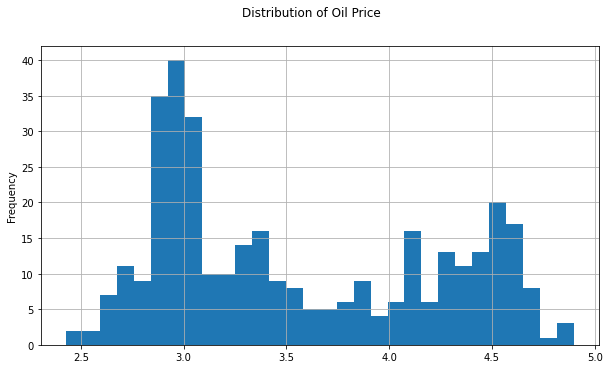

In [35]:
axes = displayDataset["Oil Price"+suffix].plot(kind='hist',bins=30, figsize=(10,5.5),subplots=True,sharex=True,sharey=True,title='Distribution of Oil Price',grid=True)

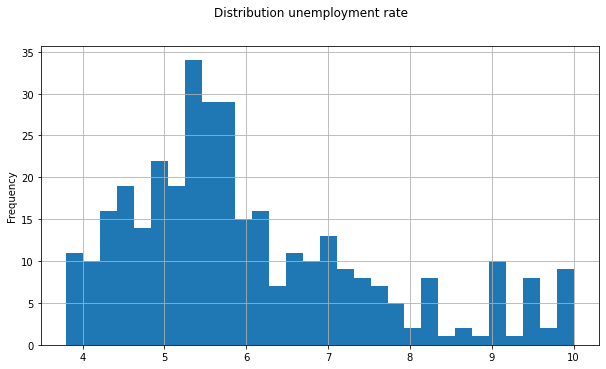

In [36]:
axes = displayDataset["Unemployment"+suffix].plot(kind='hist',bins=30, figsize=(10,5.5),subplots=True,sharex=True,sharey=True,title='Distribution unemployment rate',grid=True)

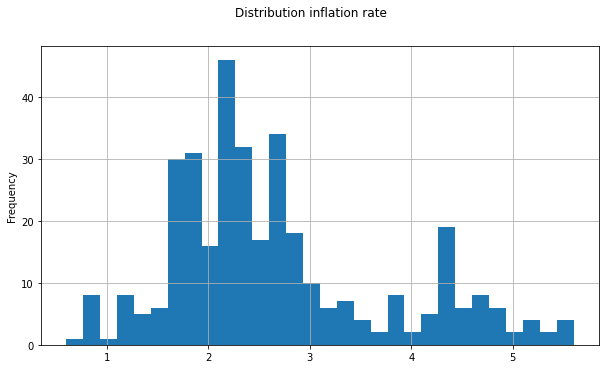

In [37]:
axes = displayDataset["Inflation Rate"+suffix].plot(kind='hist',bins=30, figsize=(10,5.5),subplots=True,sharex=True,sharey=True,title='Distribution inflation rate',grid=True)

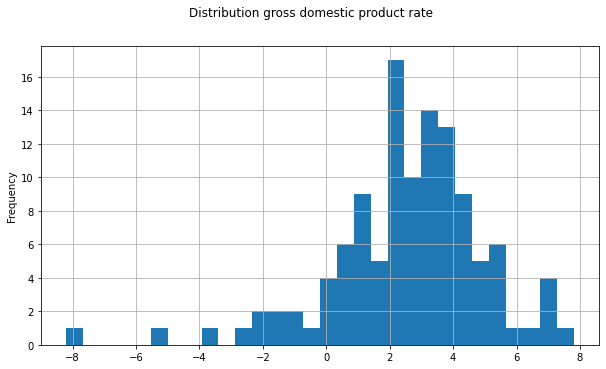

In [38]:
axes = displayDataset["GDP"+suffix].plot(kind='hist',bins=30, figsize=(10,5.5),subplots=True,sharex=True,sharey=True,title='Distribution gross domestic product rate',grid=True)

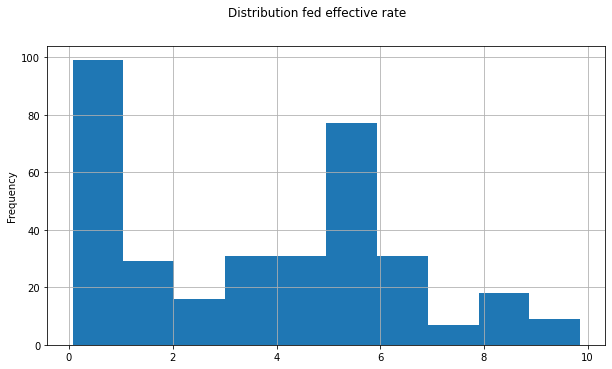

In [39]:
axes = displayDataset["FED Effective Rate"+suffix].plot(kind='hist',bins=10, figsize=(10,5.5),subplots=True,sharex=True,sharey=True,title='Distribution fed effective rate',grid=True)

##### Remark
The distributions could be designed by a distribution of gaussian but due to the fact that the data comes from a time series with increasing values this model would not be valid for extrapolation.

To gain a better data quality it could be neccessary to calculate nominal data which expresses the actual price without inflation.

## Correlation analysis of the dataset
To get a first appraisal of how the features are connected to each other a correlation matrix will be calculated this can later also be used to control the quality of the regression by observing the average response rate of a certain feature.
Furthermore the pairwise correlation of the featues is calculated with the pearson-method

In [40]:
displayDataset = pdLogDecayConvolution# pdMerged

In [41]:
def plotCorrelationMatrix(df, graphWidth):
    fsize=17
    df = df.dropna('columns') 
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90,fontsize=fsize)
    plt.yticks(range(len(corr.columns)), corr.columns,fontsize=fsize)
    plt.gca().xaxis.tick_bottom()
    plt.gcf().autofmt_xdate()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix',fontsize=(fsize+3))
    plt.show()
    return corr

In [42]:
# displayDataset.rename(columns={"National-US":"National-US"},inplace=True)

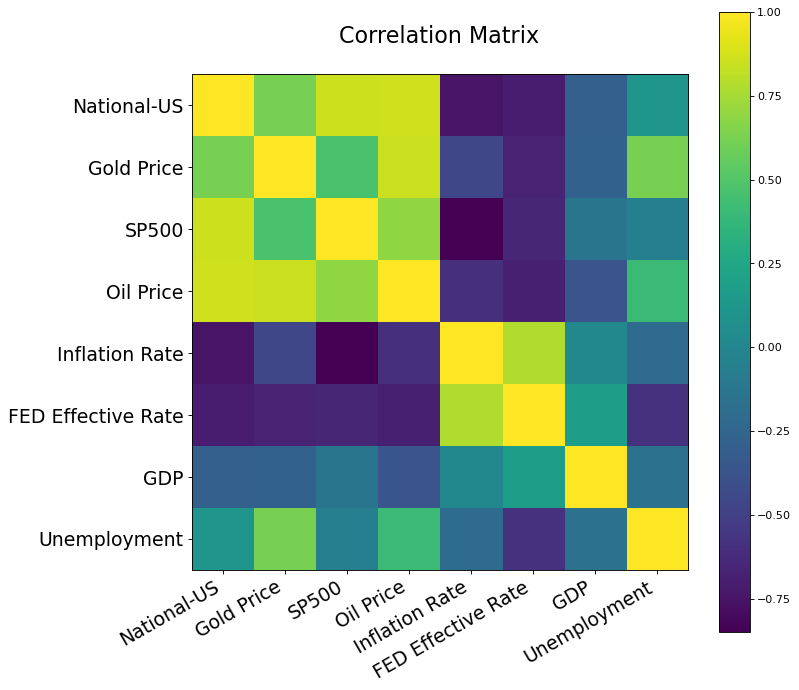

In [43]:
cor = plotCorrelationMatrix(displayDataset, 10)

In [44]:
cor

,National-US,Gold Price,SP500,Oil Price,Inflation Rate,FED Effective Rate,GDP,Unemployment
National-US,1.000000,0.624404,0.856965,0.863151,-0.750438,-0.697906,-0.283758,0.115767
Gold Price,0.624404,1.000000,0.469417,0.855217,-0.457083,-0.669106,-0.274294,0.619899
SP500,0.856965,0.469417,1.000000,0.691040,-0.848649,-0.652950,-0.128957,-0.051117
Oil Price,0.863151,0.855217,0.691040,1.000000,-0.592255,-0.684251,-0.361112,0.411504
Inflation Rate,-0.750438,-0.457083,-0.848649,-0.592255,1.000000,0.776926,0.014110,-0.202772
FED Effective Rate,-0.697906,-0.669106,-0.652950,-0.684251,0.776926,1.000000,0.182864,-0.586083
GDP,-0.283758,-0.274294,-0.128957,-0.361112,0.014110,0.182864,1.000000,-0.159078
Unemployment,0.115767,0.619899,-0.051117,0.411504,-0.202772,-0.586083,-0.159078,1.000000


In [45]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize):
    textSize = 10
    df = df.select_dtypes(include =[np.number])
    df = df.dropna('columns')
    columnNames = list(df)
    if len(columnNames) > 9:
        columnNames = columnNames[:9]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr(method="pearson").values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('%.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()
    return pd.DataFrame(corrs)


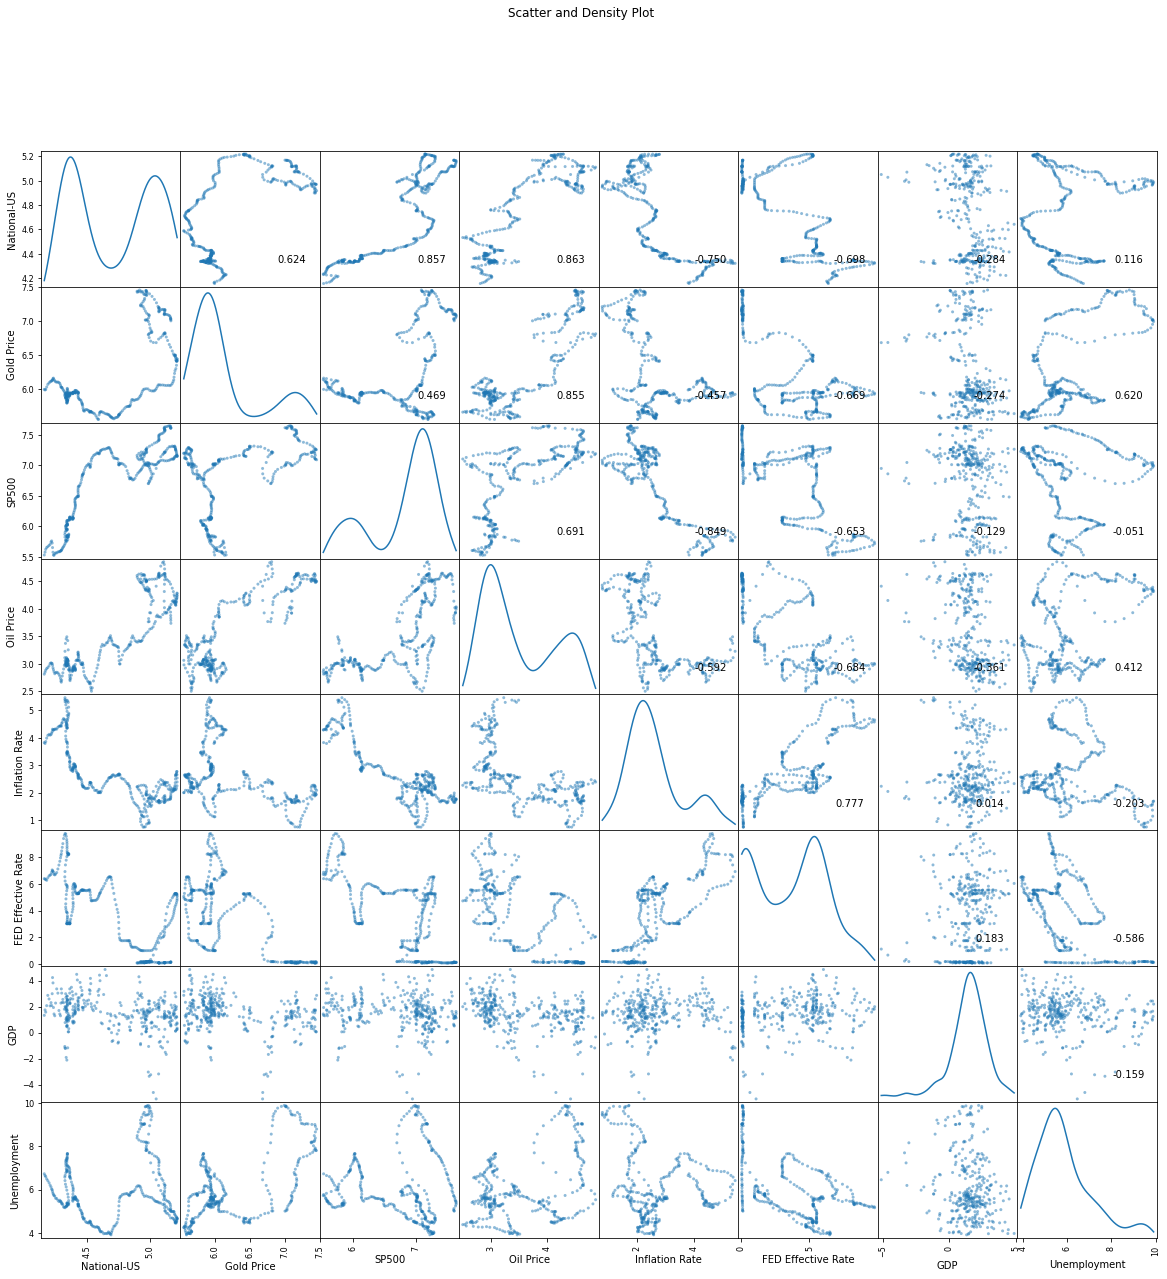

In [46]:
cor = plotScatterMatrix(displayDataset, 20)

Both correlation matrices indicate that the features except the unemployment rate are correlated with the House Prices index but in addition some features are highly correlated with each other for instance the inflation rate and both FED Effective and FED Target Rate

## Model Training

To find relationships between the House Pricing index and the features regression models will be used. The first regression method is the linear regression, this will be extended with the ridge regression to regularize the fitting. As a second approch a polynomial fitting is considered with and without the regularization 

In [47]:
#import the base package and the pipeline model
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

# decomposition for preprocess the data
from sklearn.decomposition import PCA

# simple regression models 
from sklearn.naive_bayes  import GaussianNB 
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures

# data preparation
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer   
from sklearn.preprocessing import StandardScaler

from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict

# interpret explanability
from interpret.blackbox import MorrisSensitivity
from interpret import show
from interpret.blackbox import LimeTabular
from interpret.blackbox import PartialDependence
from interpret.glassbox import ExplainableBoostingRegressor

# parameter optimization
from sklearn.model_selection import RandomizedSearchCV, ShuffleSplit
from scipy.stats import expon, reciprocal, uniform, randint

The whole dataset is splitted into two parts first a trainingsset and second a validation set to control the regression by data not used by the fitting. The size for the control set was choosen to be 33% and the Trainingsset as the remaining 67%. To fill missing values (NaN's) an Imputer strategy is used.

In [48]:
from math import floor
class SplitCollection():
    def __init__(self, data, label, sz=0.33, random_state=None, impute=True,name="Collection", ty="RND"):
        self.name = name
        feature_names = self.getFeatureNames(data)
        target_name = label.name
        self.alldata = data
        self.alllabel = label
        if ty == "RND":
            self._trainData, self._testData,self._trainLabel, self._testLabel = train_test_split(data, label, test_size=sz, random_state=101)
        else:
            data_length = len(data)
            test_length = floor(data_length*sz)
            train_length = data_length - test_length
            self._trainData = data.head(train_length)
            self._trainLabel = label.head(train_length)
            self._testData = data.tail(test_length)
            self._testLabel = label.tail(test_length)
            
        if impute:
            imputer = SimpleImputer(missing_values=np.nan, strategy='constant')
            self._trainData = imputer.fit_transform(self._trainData)
            self._testData = imputer.fit_transform(self._testData)
        
        self._pdTrainData = pd.DataFrame(data=self._trainData, index= range(self._trainData.shape[0]),columns =feature_names)
        self._pdTestData = pd.DataFrame(data=self._testData, index= range(self._testData.shape[0]),columns=feature_names)
        
    def __str__():
        return self.name
    
    def getFeatureNames(self,data):
        feature_names = []
        for col in data.columns: 
            feature_names.append(col)
        return feature_names

The "Date" is not a feature which should be considered for the training therefore it will be deleted so that this can not be used for the fitting. The depending variable (the house prices) will also be removed from the dataset and treat as a label.

In [49]:
import datetime as dt
def conv(df):
    epoch = dt.datetime(1970, 1, 1)
    #print([((d-np.datetime64('1961-01-01T00:00:00Z')) / np.timedelta64(1, 's'))/(3600*24*30) for d in df.to_numpy()])\n",
    return np.array([float(((d-np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's'))/(3600*24*30)) for d in df.to_numpy()])

In [50]:
savedDate = pdMerged["Date"].copy()
ty = "EXT" if useExtrapolation else "RND"

In [51]:
if useDateAsFeature:
    pdMerged["Date"] = pd.to_datetime(pdMerged["Date"], format='%Y-%M-%d')
    pdMerged["Date"] = conv(pdMerged["Date"])
else:
    del pdMerged["Date"]

pdLabels = pdMerged[housePriceSelector+useNomValues].copy()
pdTrain = pdMerged.drop(housePriceSelector+useNomValues, axis=1).copy()
Collection = SplitCollection(pdTrain,pdLabels,sz=test_train_ratio,random_state=101,ty=ty)


In [52]:
if useDateAsFeature:
    pdConvolutionDecay["Date"] = pd.to_datetime(pdConvolutionDecay["Date"], format='%Y-%M-%D')
    pdConvolutionDecay["Date"] = conv(pdConvolutionDecay["Date"])
else:
    del pdConvolutionDecay["Date"]
    
pdDecayLabels = pdConvolutionDecay[housePriceSelector+useNomValues].copy()
pdDecayTrain = pdConvolutionDecay.drop(housePriceSelector+useNomValues, axis=1).copy()
decayCollection = SplitCollection(pdDecayTrain, pdDecayLabels,sz=test_train_ratio,impute=False,random_state=101,ty=ty)


In [53]:
if useDateAsFeature:
    pdLogMerged["Date"] = pd.to_datetime(pdLogMerged["Date"], format='%Y-%M-%D')
    pdLogMerged["Date"] = conv(pdLogMerged["Date"])
else:
    del pdLogMerged["Date"]
pdLogLabels = pdLogMerged[housePriceSelector+useNomValues].copy()
pdLogTrain = pdLogMerged.drop(housePriceSelector+useNomValues, axis=1).copy()
logCollection = SplitCollection(pdLogTrain,pdLogLabels,sz=test_train_ratio,random_state=101, ty=ty)

In [54]:
if useDateAsFeature:
    pdLogDecayConvolution["Date"] = pd.to_datetime(pdLogDecayConvolution["Date"], format='%Y-%M-%D')
    pdLogDecayConvolution["Date"] = conv(pdLogDecayConvolution["Date"])
else:
    del pdLogDecayConvolution["Date"]
pdDecayLogLabels = pdLogDecayConvolution[housePriceSelector+useNomValues].copy()
pdDecayLogTrain = pdLogDecayConvolution.drop(housePriceSelector+useNomValues, axis=1).copy()
decayLogCollection = SplitCollection(pdDecayLogTrain,pdDecayLogLabels,sz=test_train_ratio,impute=False,random_state=101,ty=ty)

The following line will determine which dataset will be used to apply the regression algorithm. For the documentation the dataset "decayLogCollection" was used.

In [55]:
def idf(x):
    return x

algoDataset = None 
if useLoggedData:
    fun_transformation = np.exp
    if useConvolution:
        algoDataset = decayLogCollection
    else:
        algoDataset = logCollection
    
else:
    fun_transformation = idf
    if useConvolution:
        algoDataset = decayCollection
    else:
        algoDataset = Collection


In [56]:
algoDataset._trainData.head()

,Gold Price,SP500,Oil Price,Inflation Rate,FED Effective Rate,GDP,Unemployment
133,5.686809,6.887796,2.856719,2.234993,5.523157,2.489837,4.621224
69,5.845757,6.029973,3.076500,3.478554,3.199947,2.079376,7.511550
20,6.062985,5.589149,2.730449,4.437754,7.935156,1.293006,5.454505
130,5.761306,6.845797,3.014467,2.243782,5.522100,1.929624,4.723985
155,5.666986,7.224633,3.206653,2.013484,5.298255,3.991453,4.081536


In [57]:
algoDataset._testData.head()

,Gold Price,SP500,Oil Price,Inflation Rate,FED Effective Rate,GDP,Unemployment
154,5.656934,7.200609,3.157037,2.045716,5.259741,4.419461,4.137754
303,7.424812,7.219497,4.638142,2.278776,0.118867,1.111170,8.237754
86,5.950373,6.148959,2.691588,2.922336,3.191109,2.248706,6.548477
38,6.006436,5.823855,3.068069,4.629471,8.286587,2.529794,5.302761
48,5.944692,5.771993,3.370136,5.377727,7.408386,-1.226878,6.247650


## Linear Regression

In [58]:
lm = LinearRegression()
lm.fit(algoDataset._trainData, algoDataset._trainLabel)
print("linear regression score for the trainingdata:", lm.score(algoDataset._trainData,algoDataset._trainLabel))

linear regression score for the trainingdata: 0.9201768564178372


In [59]:
print("linear regression score for the testdata:", lm.score(algoDataset._testData,algoDataset._testLabel))

linear regression score for the testdata: 0.9063451492883295


In [60]:
print("Coefficients: \n", lm.coef_,"\n\nIntercept:\n", lm.intercept_)

Coefficients: 
 [-0.07778336  0.01280832  0.40702045 -0.04201628 -0.03996726 -0.00887988
 -0.08317404] 

Intercept:
 4.44995303354662


In [61]:
sensitivity = MorrisSensitivity(predict_fn=lm.predict, data=algoDataset._trainData)
sensitivity_global = sensitivity.explain_global(name="Global Sensitivity ")

show(sensitivity_global)

<!-- http://127.0.0.1:7845/1442520213656/ -->

In [62]:
pdp = PartialDependence(predict_fn=lm.predict, data=algoDataset._trainData)
pdp_global = pdp.explain_global(name='Partial Dependence')

show(pdp_global)

<!-- http://127.0.0.1:7845/1442546852976/ -->

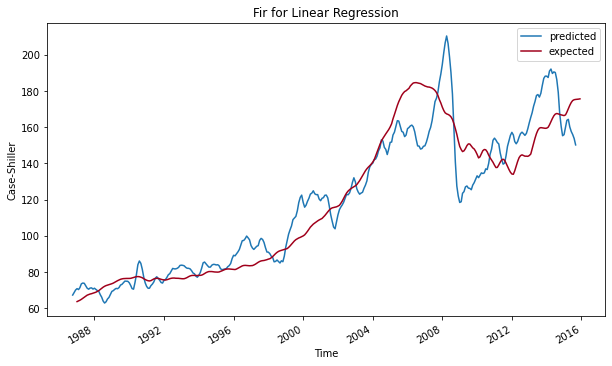

In [63]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(savedDate,fun_transformation(lm.predict(algoDataset.alldata)), label="predicted") # todo transformation
ax.plot(pdHouseprices["Date"], pdHouseprices[housePriceSelector+useNomValues], label="expected",color=colormap["houseprice"])

fig.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')

ax.set_title('Fir for Linear Regression')
ax.legend()
plt.ylabel('Case-Shiller')
plt.xlabel('Time')
plt.show()

## Ridge Regression

In [64]:
rg = Ridge(normalize=True)
cv = ShuffleSplit(n_splits=5,
                  test_size=0.1, 
                  random_state=0)
params = {#'poly__degree':randint(1,3),
          'alpha':uniform(0,10)
         # 'elastic__l1_ratio':uniform(0, 1)
         }
findparam = RandomizedSearchCV(rg,param_distributions=params, random_state=200,cv=cv,scoring='r2')
findparam.fit(algoDataset._trainData,algoDataset._trainLabel)
print(findparam.best_params_)

{'alpha': 0.0286059168094277}


In [65]:
rg = Ridge(alpha=findparam.best_params_['alpha'],normalize=True)
rg.fit(algoDataset._trainData,algoDataset._trainLabel)
print("ridge regression score for the trainingdata:", rg.score(algoDataset._trainData,algoDataset._trainLabel))

ridge regression score for the trainingdata: 0.9168314087710044


In [66]:
print("ridge regression score for the testdata:", rg.score(algoDataset._testData,algoDataset._testLabel))

ridge regression score for the testdata: 0.9044077141837169


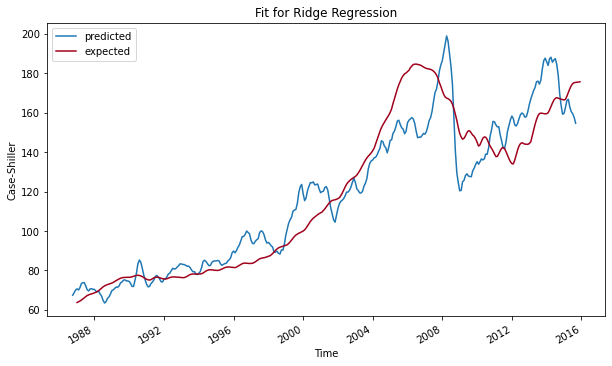

In [67]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(savedDate,fun_transformation(rg.predict(algoDataset.alldata)), label="predicted") # todo transformation
ax.plot(pdHouseprices["Date"], pdHouseprices[housePriceSelector+useNomValues], label="expected",color=colormap["houseprice"])

fig.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')

ax.set_title('Fit for Ridge Regression')
ax.legend()
plt.ylabel('Case-Shiller')
plt.xlabel('Time')
plt.show()

The ridge regression produces nearly the same results as the normal lineare regression without regularization.

## Polynomial Regression (without regularization)

To get a more complex model a curve fitting with a polynomial with degree != 1 is choosen. 

In [68]:
degree = 5

poly = PolynomialFeatures(degree)
polylm = LinearRegression()
poly_model=Pipeline([("poly",poly),("ln",polylm)])

poly_model.fit(algoDataset._trainData,algoDataset._trainLabel)
print("polynomial regression score for the trainingdata:", poly_model.score(algoDataset._trainData,algoDataset._trainLabel))

polynomial regression score for the trainingdata: 1.0


In [69]:
print("polynomial regression score for the testdata:", poly_model.score(algoDataset._testData,algoDataset._testLabel))

polynomial regression score for the testdata: 0.8479439477973602


In [70]:
sensitivity = MorrisSensitivity(predict_fn=poly_model.predict, data=algoDataset._trainData)
sensitivity_global = sensitivity.explain_global(name="Global Sensitivity ")

show(sensitivity_global)

<!-- http://127.0.0.1:7845/1442558471640/ -->

In [71]:
pdp = PartialDependence(predict_fn=poly_model.predict, data=algoDataset._trainData)
pdp_global = pdp.explain_global(name='Partial Dependence')

show(pdp_global)

<!-- http://127.0.0.1:7845/1442559450528/ -->

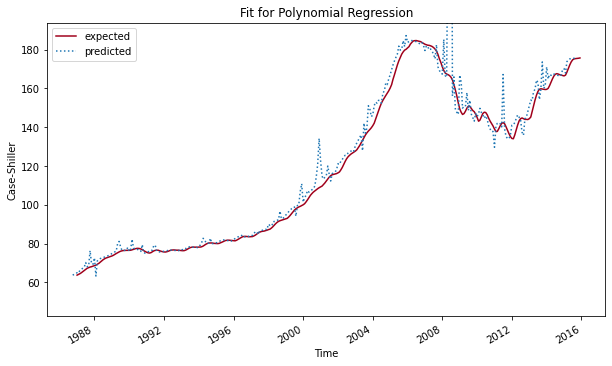

In [72]:
fig, ax = plt.subplots(figsize=(10,6))
datax = fun_transformation(poly_model.predict(algoDataset.alldata))
ax.plot(pdHouseprices["Date"], pdHouseprices[housePriceSelector+useNomValues], label="expected",color=colormap["houseprice"])
ax.plot(savedDate,datax,":", label="predicted") # todo transformation

mrhp = max(pdHouseprices[housePriceSelector+useNomValues])*1.05
mphp = max(datax)

fig.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.set_ylim((min(pdHouseprices[housePriceSelector+useNomValues])*2/3,min([mrhp,mphp])))
ax.set_title('Fit for Polynomial Regression')
ax.legend()
plt.ylabel('Case-Shiller')
plt.xlabel('Time')
plt.show()

The polynomial regression fits the trainingsdata perfectly but it does not fit the testdata for control. So here the data is overfitted so that the usage of a regularization technique is required or the degree of the polynom should choosen to be lower. 

## Polynomial Regression (Ridge regularization)

In [73]:
degree = 5
poly = PolynomialFeatures(degree)
poly_rg = Ridge(normalize=True)
poly_model=Pipeline([("poly",poly),("ridge",poly_rg)])

params = {#'poly__degree':randint(1,3),
          'ridge__alpha':uniform(0,10),
          #'elastic__l1_ratio':uniform(0, 1)
         }

cv = ShuffleSplit(n_splits=5,
                  test_size=0.1, 
                  random_state=0)

findparam = RandomizedSearchCV(poly_model,
                               param_distributions=params,
                               random_state=200,
                               cv=cv,
                               scoring='r2')

findparam.fit(algoDataset._trainData,algoDataset._trainLabel)
print(findparam.best_params_)

{'ridge__alpha': 0.0286059168094277}


In [74]:
poly = PolynomialFeatures(degree=degree)
poly_rg = Ridge(alpha=findparam.best_params_["ridge__alpha"],normalize=True)
poly_model=Pipeline([("poly",poly), ("elastic",poly_rg)])
poly_model.fit(algoDataset._trainData,algoDataset._trainLabel)
print("regularized polynomial regression score for the trainingdata:", poly_model.score(algoDataset._trainData,algoDataset._trainLabel))

regularized polynomial regression score for the trainingdata: 0.985755658045832


In [75]:
print("regularized polynomial regression score for the testdata:", poly_model.score(algoDataset._testData,algoDataset._testLabel))

regularized polynomial regression score for the testdata: 0.9795052574139352


In [76]:
sensitivity = MorrisSensitivity(predict_fn=poly_model.predict, data=algoDataset._trainData)
sensitivity_global = sensitivity.explain_global(name="Global Sensitivity ")

show(sensitivity_global)

<!-- http://127.0.0.1:7845/1442560111560/ -->

In [77]:
pdp = PartialDependence(predict_fn=poly_model.predict, data=algoDataset._trainData)
pdp_global = pdp.explain_global(name='Partial Dependence')

show(pdp_global)

<!-- http://127.0.0.1:7845/1442558373112/ -->

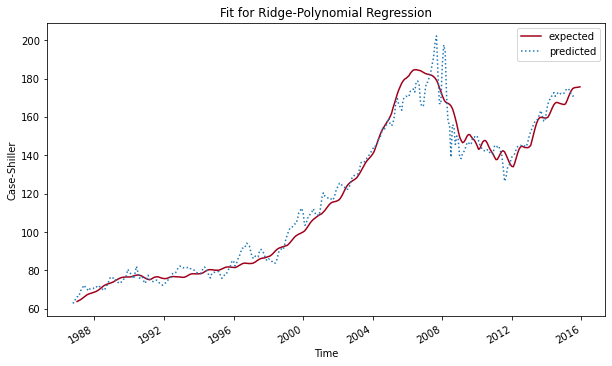

In [78]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(pdHouseprices["Date"], pdHouseprices[housePriceSelector+useNomValues], label="expected",color=colormap["houseprice"])
ax.plot(savedDate,fun_transformation(poly_model.predict(algoDataset.alldata)),":", label="predicted") # todo transformation


fig.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')

ax.set_title('Fit for Ridge-Polynomial Regression')
ax.legend()
plt.ylabel('Case-Shiller')
plt.xlabel('Time')
plt.show()

The prediction of this regularized regression fits the data well if the testdata are chosen to be within the interval of the trainingsdata. This holds true even if the ratio of test to trainingsdata is set to a higher value. Therefore the missing values of the test data can be interpolated well.
By choosing the testdata to be outside of the dateinterval used for the training the extrapolation is not suitable. Here the lineare Regression produces better results.

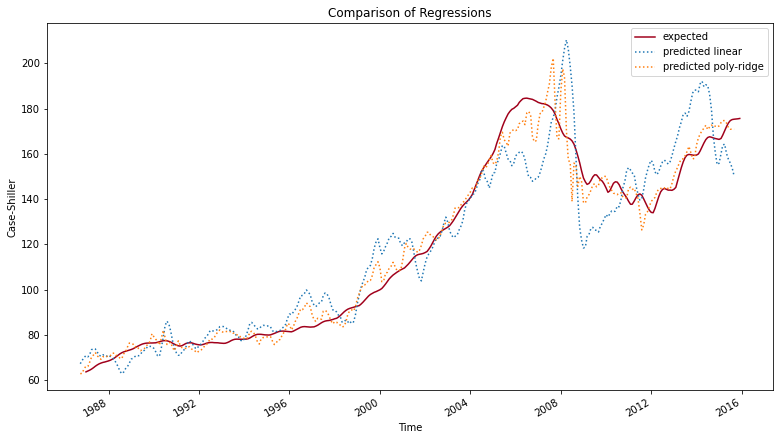

In [95]:
fig, ax = plt.subplots(figsize=(13,7.5))
ax.plot(pdHouseprices["Date"], pdHouseprices[housePriceSelector+useNomValues], label="expected",color=colormap["houseprice"])
ax.plot(savedDate,fun_transformation(lm.predict(algoDataset.alldata)),":", label="predicted linear")
ax.plot(savedDate,fun_transformation(poly_model.predict(algoDataset.alldata)),":", label="predicted poly-ridge")


fig.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')

ax.set_title('Comparison of Regressions')
ax.legend()
plt.ylabel('Case-Shiller')
plt.xlabel('Time')
plt.show()

### Overfitting ~ Degree
The overfitting of the testdata will be investigated more in detail by the following code. To do this The fitting will be applied for polynomials with different degrees.

In [80]:
method = Ridge

degree_max = 10
x_xr_vals = []
score_xr_test = []
score_xr_train = []
for degree in range(1,degree_max):
    x_xr_vals.append(degree)
    poly = PolynomialFeatures(degree)
    polylm = LinearRegression()
    poly_model_ovdeg=Pipeline([("poly",poly),("ln",polylm)])

    poly_model_ovdeg.fit(algoDataset._trainData,algoDataset._trainLabel)
    score_xr_train.append(poly_model_ovdeg.score(algoDataset._trainData,algoDataset._trainLabel))
    score_xr_test.append( poly_model_ovdeg.score(algoDataset._testData,algoDataset._testLabel))

In [81]:
degree_max = 10
x_wr_vals = []
score_wr_test = []
score_wr_train = []
for degree in range(1,degree_max):
    x_wr_vals.append(degree)

    poly = PolynomialFeatures(degree)
    poly_rg = method(normalize=True)
    poly_model_wrdeg=Pipeline([("poly",poly),("ridge",poly_rg)])

    params = {#'poly__degree':randint(1,3),
              'ridge__alpha':uniform(0,10),
              #'elastic__l1_ratio':uniform(0, 1)
             }

    cv = ShuffleSplit(n_splits=5,
                      test_size=0.1, 
                      random_state=0)

    findparam = RandomizedSearchCV(poly_model_wrdeg,
                                   param_distributions=params,
                                   random_state=200,
                                   cv=cv,
                                   scoring='r2')

    findparam.fit(algoDataset._trainData,algoDataset._trainLabel)
    
    poly = PolynomialFeatures(degree=degree)
    poly_rg = method(alpha=findparam.best_params_["ridge__alpha"],normalize=True)
    poly_model_wrdeg=Pipeline([("poly",poly), ("elastic",poly_rg)])
    poly_model_wrdeg.fit(algoDataset._trainData,algoDataset._trainLabel)
    score_wr_train.append(poly_model_wrdeg.score(algoDataset._trainData,algoDataset._trainLabel))
    
    score_wr_test.append(poly_model_wrdeg.score(algoDataset._testData,algoDataset._testLabel))
    #plt.plot(savedDate,fun_transformation(poly_model.predict(pdDecayLogTrain)), ":")

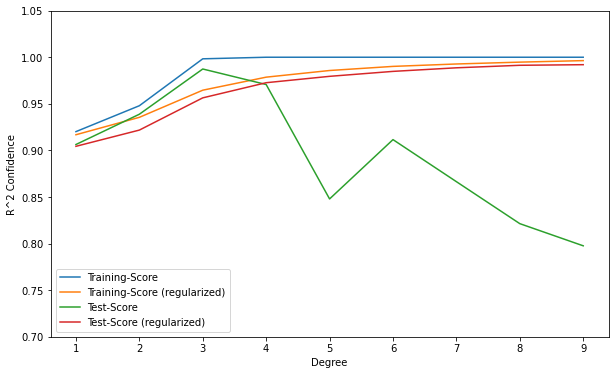

In [82]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(x_xr_vals,score_xr_train, label="Training-Score")
ax.plot(x_wr_vals,score_wr_train, label="Training-Score (regularized)")
ax.plot(x_xr_vals,score_xr_test,label="Test-Score")
ax.plot(x_wr_vals,score_wr_test,label="Test-Score (regularized)")


ax.set_title('')
ax.legend()
ax.set_ylim((0.7,1.05))
plt.ylabel('R^2 Confidence')
plt.xlabel('Degree')
plt.show()


The degree of the polynomial should be greater than two if there is no regularization is used. The degree for the polynomial with regularization can be chosen to be greater and still get a better model. However it should also be choosen to be small to prevent oscillation.

## Explainable Boost Regressor

Another approch for regression is the Gradiant Boosting Regression (see for instance: https://towardsdatascience.com/understanding-gradient-boosting-machines-9be756fe76ab ) 

In [83]:
ebm = ExplainableBoostingRegressor(random_state=1)
ebm.fit(algoDataset._trainData,algoDataset._trainLabel)

ExplainableBoostingRegressor(binning_strategy='quantile', data_n_episodes=2000,
                             early_stopping_run_length=50,
                             early_stopping_tolerance=1e-05,
                             feature_names=['Gold Price', 'SP500', 'Oil Price',
                                            'Inflation Rate',
                                            'FED Effective Rate', 'GDP',
                                            'Unemployment'],
                             feature_step_n_inner_bags=0,
                             feature_types=['continuous', 'continuous',
                                            'continuous', 'continuous',
                                            'continuous', 'continuous',
                                            'continuous'],
                             holdout_size=0.15, holdout_split=0.15,
                             interactions=0, learning_rate=0.01,
                             main_attr='all', max_n_bins=2

In [84]:
print("ebm score for the trainingdata:", ebm.score(algoDataset._trainData,algoDataset._trainLabel))

ebm score for the trainingdata: 0.9981149600805699


In [85]:
print("ebm score for the trainingdata:", ebm.score(algoDataset._testData,algoDataset._testLabel))

ebm score for the trainingdata: 0.9886315570581632


In [86]:
ebm_global = ebm.explain_global(name='EBM')
show(ebm_global)

<!-- http://127.0.0.1:7845/1442512777112/ -->

In [87]:
ebm_local = ebm.explain_local(algoDataset._trainData[:5], algoDataset._trainLabel[:5], name='EBM')
for explanation in ebm_local._internal_obj['specific']: # deleting the intercept from plotting
    del explanation['extra']
show(ebm_local)

<!-- http://127.0.0.1:7845/1442513260672/ -->

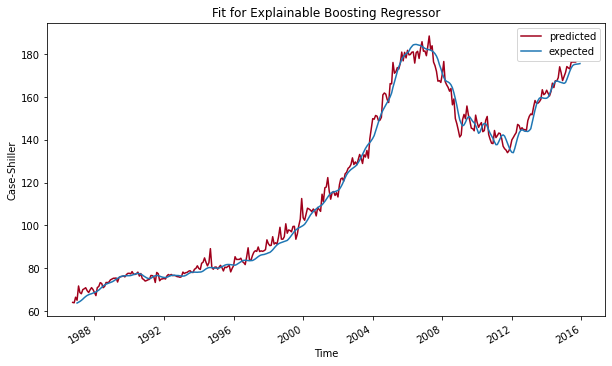

In [88]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(savedDate,fun_transformation(ebm.predict(algoDataset.alldata)), label="predicted",color=colormap["houseprice"]) # todo transformation
ax.plot(pdHouseprices["Date"], pdHouseprices[housePriceSelector+useNomValues], label="expected")

fig.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')

ax.set_title('Fit for Explainable Boosting Regressor')
ax.legend()
plt.ylabel('Case-Shiller')
plt.xlabel('Time')
plt.show()

This method fits the data as well as the linear regression and does not extrapolate the data

### Support Vector Regression
To get a model which also can be used for the extrapolation the Support Vector Regression is considered as the final Regression method. (See https://towardsdatascience.com/https-medium-com-pupalerushikesh-svm-f4b42800e989 ) 

In [89]:
svr_rbf = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=10,gamma=0.07,epsilon=0.01, degree=3,max_iter=500000))
svr_rbf.fit(algoDataset._trainData, algoDataset._trainLabel)
print("Support Vector Regression score for Trainingsdata:\t",svr_rbf.score(algoDataset._trainData,algoDataset._trainLabel))
print("Support Vector Regression score for Testdata:\t\t",svr_rbf.score(algoDataset._testData,algoDataset._testLabel))

Support Vector Regression score for Trainingsdata:	 0.9985652959153389
Support Vector Regression score for Testdata:		 0.9963386902486014


In [90]:
sensitivity = MorrisSensitivity(predict_fn=svr_rbf.predict, data=algoDataset._trainData)
sensitivity_global = sensitivity.explain_global(name="Global Sensitivity ")

show(sensitivity_global)

<!-- http://127.0.0.1:7845/1442504139496/ -->

In [91]:
pdp = PartialDependence(predict_fn=lm.predict, data=algoDataset._trainData)
pdp_global = pdp.explain_global(name='Partial Dependence')

show(pdp_global)

<!-- http://127.0.0.1:7845/1442560411520/ -->

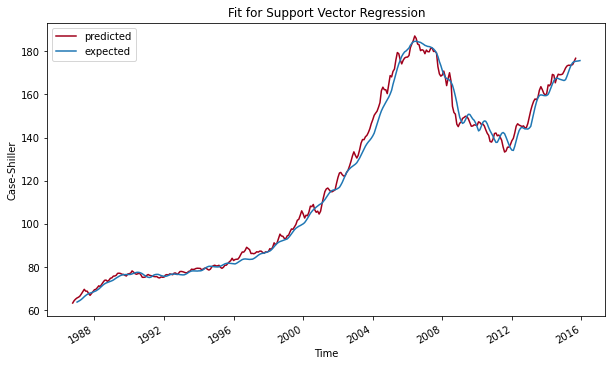

In [92]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(savedDate,fun_transformation(svr_rbf.predict(algoDataset.alldata)), label="predicted",color=colormap["houseprice"]) # todo transformation
ax.plot(pdHouseprices["Date"], pdHouseprices[housePriceSelector+useNomValues], label="expected")

fig.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')

ax.set_title('Fit for Support Vector Regression')
ax.legend()
plt.ylabel('Case-Shiller')
plt.xlabel('Time')
plt.show()

The Support Vector Regression can extrapolate the data outside of the trainingsinterval when the nominal data is used and the size of the testdata is not too big compared to the trainingsdata size. It could be possible that the data must be prepared in a different manner to get better results for the extrapolation.

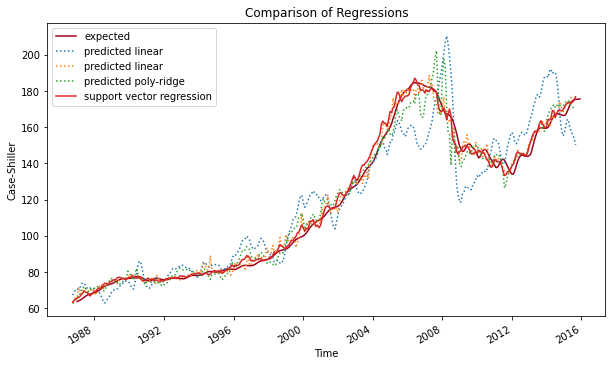

In [93]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(pdHouseprices["Date"], pdHouseprices[housePriceSelector+useNomValues], label="expected",color=colormap["houseprice"])
ax.plot(savedDate,fun_transformation(lm.predict(algoDataset.alldata)),":", label="predicted linear")
ax.plot(savedDate,fun_transformation(ebm.predict(algoDataset.alldata)),":", label="predicted linear")
ax.plot(savedDate,fun_transformation(poly_model.predict(algoDataset.alldata)),":", label="predicted poly-ridge")
ax.plot(savedDate,fun_transformation(svr_rbf.predict(algoDataset.alldata)), "-",label="support vector regression") # todo transformation

fig.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')

ax.set_title('Comparison of Regressions')
ax.legend()
plt.ylabel('Case-Shiller')
plt.xlabel('Time')
plt.show()